adversarial network to build synthetic data. Adversarial generator code taken from https://www.kaggle.com/code/meetnagadia/handwritten-digits-generator-with-a-gan/notebook

In [3]:
#Importing libraries

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms 

In [4]:
# allowing reproducibility 
torch.manual_seed(111)

In [5]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("gpu available")
else:
    device = torch.device("cpu")
    print("gpu not aviailable")


gpu not aviailable


In [6]:
# converting the data to tensors and setting the rage of weights to -1,1 instead of 0,1
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
])

In [7]:
#loading the training data and apply the transformations

train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

In [8]:
#Setting batch size and variables

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

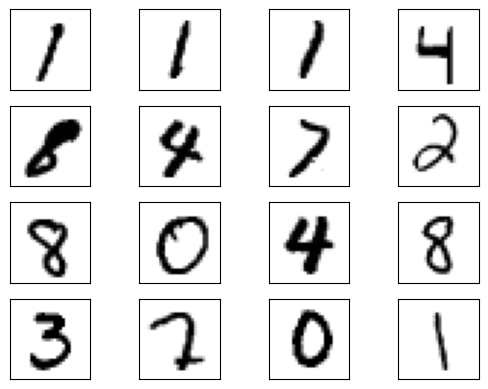

In [9]:
#Plotting the real MNIST data

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [10]:
# the discriminator model that takes in the image and returns the probability of that image being in the dataset
#We want this model to have a hard time distinguishing between the generated data and the real data

class Discriminator (nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [11]:
# this model generates the data, which is fed a 100 dimensional input and 
# returns a 784 coefficient output that is arranged in a 28x28 tensor representing a pixel image

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
generator = Generator().to(device=device)

In [12]:
# training the model with these parameters, adjusted based on computer hardware
lr = 0.0002
num_epochs = 70
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [13]:
# Training loop for the GAN:
# For each epoch, we do the following:
#
# 1. Train the discriminator:
#    - Generate fake samples using the generator.
#    - Label real samples as 1 and fake samples as 0.
#    - The discriminator learns to tell the difference between real and fake samples.
#    - Update the discriminator's weights based on its performance.
#
# 2. Train the generator:
#    - Generate new fake samples.
#    - The generator tries to "fool" the discriminator into thinking these are real.
#    - Update the generator's weights based on how well it fools the discriminator.
#
# After each epoch,the losses of both the discriminator and generator are printed.
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            


Epoch: 0 Loss D.: 0.6329267024993896
Epoch: 0 Loss G.: 0.780654788017273
Epoch: 1 Loss D.: 0.05139261484146118
Epoch: 1 Loss G.: 6.936619281768799
Epoch: 2 Loss D.: 0.16329436004161835
Epoch: 2 Loss G.: 3.2025058269500732
Epoch: 3 Loss D.: 0.2486719787120819
Epoch: 3 Loss G.: 2.7324323654174805
Epoch: 4 Loss D.: 0.2997073829174042
Epoch: 4 Loss G.: 2.6132168769836426
Epoch: 5 Loss D.: 0.30064070224761963
Epoch: 5 Loss G.: 2.1841001510620117
Epoch: 6 Loss D.: 0.3218051493167877
Epoch: 6 Loss G.: 1.3514667749404907
Epoch: 7 Loss D.: 0.5480864644050598
Epoch: 7 Loss G.: 1.6861417293548584
Epoch: 8 Loss D.: 0.3261135518550873
Epoch: 8 Loss G.: 1.5113581418991089
Epoch: 9 Loss D.: 0.5801928639411926
Epoch: 9 Loss G.: 1.0999205112457275
Epoch: 10 Loss D.: 0.4336114823818207
Epoch: 10 Loss G.: 1.0139386653900146
Epoch: 11 Loss D.: 0.4700649082660675
Epoch: 11 Loss G.: 1.3970098495483398
Epoch: 12 Loss D.: 0.5756510496139526
Epoch: 12 Loss G.: 1.008920431137085
Epoch: 13 Loss D.: 0.53955882787

NameError: name 'checkpoint_path' is not defined

In [14]:
# Save the model state after training is complete since training takes a long time 

checkpoint_path = "gan_model_final.pth"

torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_generator_state_dict': optimizer_generator.state_dict(),
    'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
}, checkpoint_path)

print("Final model saved.")

Final model saved.


In [15]:
# obtaining the adversarial examples
latent_space_samples = torch.randn(batch_size, 100)
generated_samples = generator(latent_space_samples)

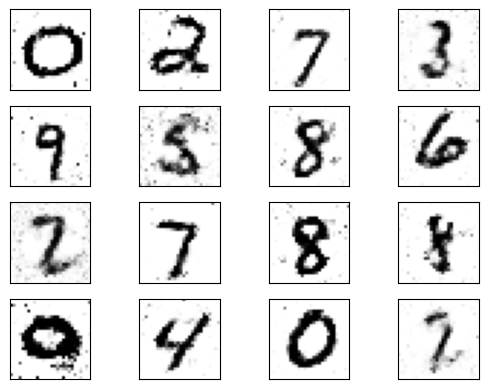

In [16]:
#plotting the adversarial examples generated 
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [17]:
# generating a total of 10000 adversarial examples to help train our student model

num_samples_to_generate = 10000 
latent_dim = 100

generated_samples = []
for _ in range(num_samples_to_generate // batch_size):
    # Generate random noise
    latent_space_samples = torch.randn(batch_size, latent_dim)
    
   
    with torch.no_grad(): 
        generated_batch = generator(latent_space_samples)  
        generated_samples.append(generated_batch)

# Combining all generated samples into a single tensor
generated_samples = torch.cat(generated_samples)  

In [21]:
# importing numpy into the project

import numpy as np

In [23]:
#converting the generated samples to a numpy array and saving them 

generated_samples_np = generated_samples.cpu().numpy()  

# Save to .npy file
np.save('generated_samples.npy', generated_samples_np)

In [24]:
# importing the teacher model that is trained on the mnist dataset using keras sequential 
#CNN model that has 2 convolutional layers, 2 max pooling layers, one flattten layer and 2 dense layers

from tensorflow.keras.models import load_model
teacher_model = load_model('../models/teacher_model.h5')


In [26]:

# Storing the teacher model predictions on the adversarial examples. These will be used as the labels for the adversarial examples

generated_samples_numpy = generated_samples_np.reshape(-1, 28, 28)   
soft_labels = teacher_model.predict(generated_samples_numpy)


312/312 [==============================] - 0s 1ms/step


In [27]:
#The adversarial examples generated from the GAN have coefficients that range from [-1,1]
# In order for the data to work with our pretrained model its range must be normalized back to the range [0,1]
normalized_samples = (generated_samples_numpy + 1) / 2.0
normalized_samples = normalized_samples.reshape(-1, 28, 28) 

In [33]:
# Downloading the train images and labels to be used in combination with the adversarial examples
# To format the data it went through the same standard preprocessing (normalizing and reshaping). 
# The predicted labels are formatted to have the correct numpy shape

mnist_dataset = torchvision.datasets.MNIST(root='data', train=True, download=True)
mnist_images, mnist_labels = mnist_dataset.data, mnist_dataset.targets


mnist_images_np = mnist_images.numpy().astype('float32') / 255.0  # Normalize to [0, 1]
mnist_labels_np = mnist_labels.numpy()

mnist_images_np = mnist_images_np.reshape(-1, 28, 28)
# Convert soft labels to class indices (1D)
soft_labels_class_indices = np.argmax(soft_labels, axis=1) 

In [50]:
#Creating the train dataset by combining the mnist real data and the mnist 
combined_images = np.concatenate((mnist_images_np, normalized_samples), axis=0)
combined_labels = np.concatenate((mnist_labels_np, soft_labels_class_indices), axis=0)

# one hot encoding the labels 
combined_labels_one_hot = keras.utils.to_categorical(combined_labels, num_classes=10)  # Convert to one-hot

print("Combined Images Shape:", combined_images.shape)
print("Combined Labels Shape:", combined_labels_one_hot.shape)

Combined Images Shape: (69984, 28, 28)
Combined Labels Shape: (69984, 10)


In [91]:
# loading the student models that are evaluated 

#student model that is trained on the combined (adversarial and pure) dataset using KD
student_model = load_model('../models/student_model.h5')

# student model used that is not trained using KD
scratch_student_model = load_model('../models/student_model.h5')

# student model trained on adversarial examples using KD
student_model_adv = load_model('../models/student_model.h5')

In [58]:
# code taken from keras.io https://keras.io/examples/vision/knowledge_distillation/
import keras
import tensorflow as tf

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

In [89]:
from keras import metrics, losses

# The distiller that takes the combined data
distiller = Distiller(student=student_model, teacher=teacher_model)

# Compiling the Distiller
distiller.compile(
    optimizer=keras.optimizers.Adam(),  
    metrics=[metrics.CategoricalAccuracy()],  
    student_loss_fn=losses.CategoricalCrossentropy(from_logits=True), 
    distillation_loss_fn=losses.KLDivergence(),  
    alpha=0.1,  
    temperature=3, 
)



history = distiller.fit(
    combined_images,
    combined_labels_one_hot,
    epochs=3, 
    batch_size=32,  
    validation_split=0.2, 
)

Epoch 1/3
1750/1750 [==============================] - 6s 3ms/step - categorical_accuracy: 0.9966 - val_categorical_accuracy: 0.8567
Epoch 2/3
1750/1750 [==============================] - 6s 3ms/step - categorical_accuracy: 0.9970 - val_categorical_accuracy: 0.8523
Epoch 3/3
1750/1750 [==============================] - 6s 3ms/step - categorical_accuracy: 0.9972 - val_categorical_accuracy: 0.8558


In [85]:
#Accuracy on the training data

distiller.evaluate(combined_images, combined_labels_one_hot)

2187/2187 [==============================] - 2s 785us/step - categorical_accuracy: 0.9635


0.9635059237480164

In [79]:
# importing the test data to evaluate the student model
mnist_test_dataset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
mnist_test_images = mnist_test_dataset.data.numpy()
mnist_test_labels = mnist_test_dataset.targets.numpy()

mnsit_test_images = mnist_test_images.reshape((10000, 28, 28, 1))
mnist_test_images = mnist_test_images.astype('float32')/255

mnist_test_labels = keras.utils.to_categorical(mnist_test_labels)

# one hot encoding the mnist train labels 
mnist_labls_np_one_hot = keras.utils.to_categorical(mnist_labels_np)

In [90]:
#Evaluating the accuracy of the student model that has KD with both adversarial examples and pure MNIST examples

distiller.evaluate(mnsit_test_images, mnist_test_labels)

313/313 [==============================] - 0s 821us/step - categorical_accuracy: 0.8135


0.8134999871253967

In [81]:
#Compiling the student model that does not learn throguh KD
scratch_student_model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
#Fitting the student model with no KD

scratch_student_model.fit(mnist_images_np, mnist_labls_np_one_hot, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2825 - accuracy: 0.9171
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1005 - accuracy: 0.9699
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0724 - accuracy: 0.9789
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0598 - accuracy: 0.9819
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0517 - accuracy: 0.9845


In [83]:
# Evaluating the accuracy of the student model with no KD
scratch_student_model.evaluate(mnsit_test_images, mnist_test_labels)

313/313 [==============================] - 0s 855us/step - loss: 239.6576 - accuracy: 0.7510


[239.65762329101562, 0.7509999871253967]

In [92]:
#Formatting the adversarial labels by one-hot encoding

adv_labels_one_hot = keras.utils.to_categorical(soft_labels_class_indices, num_classes=10)

In [93]:
# Using Knowledge Distillation (KD) on adversarial examples:
# Using the  Distiller class to transfer knowledge from the teacher model to the student model.

distiller_adv = Distiller(student=student_model, teacher=teacher_model)

# Compile the Distiller
distiller_adv.compile(
    optimizer=keras.optimizers.Adam(),  
    metrics=[metrics.CategoricalAccuracy()],  # Change if using one-hot encoding
    student_loss_fn=losses.CategoricalCrossentropy(from_logits=True), 
    distillation_loss_fn=losses.KLDivergence(),  # Distillation loss
    alpha=0.1,  # Adjust alpha based on your requirements
    temperature=3,  # Adjust temperature as needed
)


# Fitting the distiller on the adversarial data
history_adv = distiller_adv.fit(
    normalized_samples, # 
    adv_labels_one_hot,
    epochs=3,  
    batch_size=32,  #
    validation_split=0.2,  
)

Epoch 1/3


C:\Users\hanki\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 2s 4ms/step - categorical_accuracy: 0.7232 - val_categorical_accuracy: 0.8267
Epoch 2/3
250/250 [==============================] - 1s 4ms/step - categorical_accuracy: 0.8370 - val_categorical_accuracy: 0.8478
Epoch 3/3
250/250 [==============================] - 1s 4ms/step - categorical_accuracy: 0.8533 - val_categorical_accuracy: 0.8463


In [96]:
#Evaluating the student model's accuracy trained only on adversarial examples

distiller_adv.evaluate(mnsit_test_images, mnist_test_labels)

313/313 [==============================] - 0s 824us/step - categorical_accuracy: 0.8819


0.8819000124931335